In [47]:
import enum
import strenum
import sys
from typing import Callable, TypeAlias
import torch
import torch.nn as nn
import torch.nn.functional as F
from mishax import ast_patcher
from mishax import safe_greenlet
import numpy as np
import matplotlib.pyplot as plt
import odeformer

import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

In [48]:
from odeformer.model import SymbolicTransformerRegressor
from transformer import MultiHeadAttention, TransformerFFN

from odeformer.metrics import r2_score

In [49]:
class Site(strenum.StrEnum):
    """Instrumentation sites within an ODEFormer forward pass."""
    # Attention sites
    QUERY = enum.auto()
    KEY = enum.auto()
    VALUE = enum.auto()
    ATTN_SCORES = enum.auto()
    ATTN_PROBS = enum.auto()
    ATTN_OUTPUT = enum.auto()
    POST_ATTN_RESIDUAL = enum.auto()

    # Layer norm sites
    PRE_ATTN_LAYERNORM = enum.auto()
    PRE_MLP_LAYERNORM = enum.auto()

    # MLP sites
    MLP_INPUT = enum.auto()
    MLP_HIDDEN = enum.auto()
    MLP_OUTPUT = enum.auto()
    POST_MLP_RESIDUAL = enum.auto()

    # Cross attention (decoder only)
    CROSS_ATTN_SCORES = enum.auto()
    CROSS_ATTN_PROBS = enum.auto()
    CROSS_ATTN_OUTPUT = enum.auto()

class ModulePathMapper:
    """Maps modules to their full paths including component names."""
    def __init__(self, model):
        self.path_map = {}
        self.model = model

        # Get paths from transformer components
        if hasattr(model, 'model'):
            model = model.model
            if hasattr(model, 'encoder'):
                for name, module in model.encoder.named_modules():
                    self.path_map[id(module)] = f"encoder.{name}"

            if hasattr(model, 'decoder'):
                for name, module in model.decoder.named_modules():
                    self.path_map[id(module)] = f"decoder.{name}"

    def get_layer_path(self, module: nn.Module, accessing_component: str = None) -> str:
        """Gets the full hierarchical path including the accessed component."""
        base_path = self.path_map.get(id(module))
        if base_path is None:
            return None

        # If accessing a specific component, append it
        if accessing_component:
            return f"{base_path}.{accessing_component}"

        return base_path

    def get_accessing_component(self, module: nn.Module, attr_name: str) -> str:
        """Gets the name of the component being accessed."""
        if hasattr(module, attr_name):
            component = getattr(module, attr_name)
            if isinstance(component, nn.Linear):
                return attr_name
        return None

_path_mapper = None

def _tag(module: nn.Module, site: Site, value: torch.Tensor, accessing: str = None) -> torch.Tensor:
    """Tags a value at a particular site for instrumentation."""
    try:
        parent = safe_greenlet.getparent()
        if parent is None:
            return value

        # Get full path including component
        path = None
        if _path_mapper is not None:
            path = _path_mapper.get_layer_path(module, accessing)

        ret = parent.switch((site, value, path))
        return ret if ret is not None else value
    except Exception as e:
        print(f"Error in tag at {site}: {e}")
        return value


def collect_activations_during_fit(model, times, trajectories):
    """Collects activations during model.fit()."""
    global _path_mapper
    _path_mapper = ModulePathMapper(model)
    return collect_activations(lambda: model.fit(times, trajectories))

def view_layer_paths(activations):
    """Displays activations organized by full layer paths."""
    print("\nActivations by Layer Path:")
    print("-------------------------")

    # Group by model section and type
    sections = {
        'encoder': {
            'attention': [],
            'ffn': []
        },
        'decoder': {
            'attention': [],
            'ffn': [],
            'encoder_attn': []
        }
    }

    # Collect unique paths and sort them
    for site_data in activations.values():
        for path in site_data.keys():
            if path is None:
                continue

            # Determine section and type
            if 'encoder.' in path:
                if any(x in path for x in ['q_lin', 'k_lin', 'v_lin', 'out_lin']):
                    sections['encoder']['attention'].append(path)
                elif any(x in path for x in ['lin1', 'lin2']):
                    sections['encoder']['ffn'].append(path)
            elif 'decoder.' in path:
                if 'encoder_attn' in path:
                    sections['decoder']['encoder_attn'].append(path)
                elif any(x in path for x in ['q_lin', 'k_lin', 'v_lin', 'out_lin']):
                    sections['decoder']['attention'].append(path)
                elif any(x in path for x in ['lin1', 'lin2']):
                    sections['decoder']['ffn'].append(path)

    # Print organized by section
    for section in ['encoder', 'decoder']:
        print(f"\n{section.upper()}:")
        for component_type, paths in sections[section].items():
            if paths:
                print(f"\n  {component_type}:")
                for path in sorted(set(paths)):
                    # Find this path in activations
                    for site, site_data in activations.items():
                        if path in site_data:
                            print(f"    {path}:")
                            for shape, tensor in site_data[path].items():
                                print(f"      Shape {shape}: {tensor.shape[0]} activations")

def install():
    """Installs the patchers to instrument the model."""
    print("\nInstalling patches...")

    PREFIX = f"""from {__name__} import Site, _tag as tag"""


    patcher = ast_patcher.ModuleASTPatcher(
        odeformer.model.transformer,
        ast_patcher.PatchSettings(
            prefix=PREFIX,
            allow_num_matches_upto={}  # If need to allow multiple matches
        ),
        MultiHeadAttention=[
            # Self-attention computation chain
            """        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, qlen, klen)""",
            """        scores = tag(self, Site.ATTN_SCORES, torch.matmul(q, k.transpose(2, 3)), accessing='scores')  # (bs, n_heads, qlen, klen)""",

            """        weights = F.softmax(scores.float(), dim=-1).type_as(scores)""",
            """        weights = tag(self, Site.ATTN_PROBS, F.softmax(scores.float(), dim=-1).type_as(scores), accessing='weights')""",

            """        context = torch.matmul(weights, v)""",
            """        context = tag(self, Site.ATTN_OUTPUT, torch.matmul(weights, v), accessing='context')"""
        ],
        TransformerModel=[
            # LayerNorm and attention
            """            attn = self.attentions[i](tensor, attn_mask, use_cache=use_cache)""",
            """            attn = tag(self, Site.ATTN_OUTPUT, self.attentions[i](tensor, attn_mask, use_cache=use_cache), accessing='attention_layer')"""
        ],
        TransformerFFN=[
            # Inside FFN
            """        x = self.lin1(input)""",
            """        x = self.lin1(tag(self, Site.MLP_INPUT, input, accessing='lin1'))""",

            """        x = self.lin2(x)""",
            """        x = tag(self, Site.MLP_OUTPUT, self.lin2(x), accessing='lin2')""",
        ]
    )

    try:
        patcher.install()
        print("\nPatches installed successfully")
    except Exception as e:
        print(f"\nError installing patches: {e}")
        import traceback
        traceback.print_exc()

    return patcher



def collect_activations(model_fn):
    """Collects activations during a model function execution."""
    print("\nStarting activation collection")
    activations = {}

    patcher = install()
    with patcher():
        def run_in_greenlet():
            try:
                print("Starting model execution in greenlet...")
                result = model_fn()
                print("Model execution completed")
                return result
            except Exception as e:
                print(f"Error in greenlet execution: {e}")
                import traceback
                traceback.print_exc()
                raise

        glet = safe_greenlet.SafeGreenlet(run_in_greenlet)
        print(f"Created SafeGreenlet: {glet}")

        with glet:
            try:
                print("Starting greenlet...")
                result = glet.switch()
                print("Initial switch complete")

                while glet:
                    site, value, name = result

                    # Initialize storage for this site if needed
                    if site not in activations:
                        activations[site] = {}

                    # Store by name within each site
                    if name not in activations[site]:
                        activations[site][name] = []

                    if torch.is_tensor(value):
                        activations[site][name].append(value.detach().cpu())

                    try:
                        result = glet.switch(value)
                    except StopIteration:
                        break

            except Exception as e:
                print(f"Error in activation collection: {e}")
                import traceback
                traceback.print_exc()
                raise

    print(f"Collection complete. Found sites: {list(activations.keys())}")

    if activations:
        print("\nProcessing activations...")

        # Process activations into a more structured format
        processed_activations = {}
        for site, name_data in activations.items():
            processed_activations[site] = {}

            for name, tensor_list in name_data.items():
                # Group tensors by shape
                shape_groups = {}
                for tensor in tensor_list:
                    shape = tuple(tensor.shape)
                    if shape not in shape_groups:
                        shape_groups[shape] = []
                    shape_groups[shape].append(tensor)

                # Store processed data
                processed_activations[site][name] = {
                    shape: torch.stack(tensors)
                    for shape, tensors in shape_groups.items()
                }

            # Print information
            print(f"\n{site}:")
            for name in processed_activations[site]:
                print(f"  Name: {name}")
                for shape, tensor in processed_activations[site][name].items():
                    print(f"    Shape {shape}: {tensor.shape[0]} tensors")

    return processed_activations, result

In [50]:
# First install patches
install()


Installing patches...

Patches installed successfully


In [51]:
model = SymbolicTransformerRegressor(
    from_pretrained=True)

model_args = {'beam_size':20,
        'beam_temperature':0.1}
model.set_model_args(model_args)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [52]:
with open('lotka_volterra.pkl', 'rb') as f:
    solutions = pickle.load(f)

In [53]:
# Then collect activations
np.infty=np.inf
times = np.linspace(0, 10, 50)
x = np.cos(times+.1)
y = np.sin(times+.1)
trajectory = np.stack([x, y], axis=1)

In [54]:
trajectory=solutions[0]['solution']
times = solutions[0]['time_points']

In [55]:
#model.fit(times, trajectory)
fit_activations, outputs = collect_activations_during_fit(model, times, trajectory)


Starting activation collection

Installing patches...

Patches installed successfully
Created SafeGreenlet: <SafeGreenlet object at 0x7fb279a36380 (otid=0x(nil)) pending>
Starting greenlet...
Starting model execution in greenlet...
Initial switch complete
Model execution completed
Collection complete. Found sites: [<Site.ATTN_SCORES: 'ATTN_SCORES'>, <Site.ATTN_PROBS: 'ATTN_PROBS'>, <Site.ATTN_OUTPUT: 'ATTN_OUTPUT'>, <Site.MLP_INPUT: 'MLP_INPUT'>, <Site.MLP_OUTPUT: 'MLP_OUTPUT'>]

Processing activations...

ATTN_SCORES:
  Name: encoder.attentions.0.scores
    Shape (1, 16, 100, 100): 1 tensors
  Name: encoder.attentions.1.scores
    Shape (1, 16, 100, 100): 1 tensors
  Name: encoder.attentions.2.scores
    Shape (1, 16, 100, 100): 1 tensors
  Name: encoder.attentions.3.scores
    Shape (1, 16, 100, 100): 1 tensors
  Name: decoder.attentions.0.scores
    Shape (1, 16, 1, 1): 1 tensors
    Shape (1, 16, 1, 2): 1 tensors
    Shape (1, 16, 1, 3): 1 tensors
    Shape (1, 16, 1, 4): 1 tensor

In [56]:
outputs[0][0]

0.4878 * x_0 + -0.1872 * x_0 * x_1 | -0.3038 * x_1 + 0.2110 * x_0 * x_1

In [57]:
view_layer_paths(fit_activations)


Activations by Layer Path:
-------------------------

ENCODER:

  ffn:
    encoder.ffns.0.lin1:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.0.lin2:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.1.lin1:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.1.lin2:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.2.lin1:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.2.lin2:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.3.lin1:
      Shape (1, 100, 256): 1 activations
    encoder.ffns.3.lin2:
      Shape (1, 100, 256): 1 activations

DECODER:

  ffn:
    decoder.ffns.0.lin1:
      Shape (1, 1, 512): 28 activations
      Shape (20, 1, 512): 28 activations
    decoder.ffns.0.lin2:
      Shape (1, 1, 512): 28 activations
      Shape (20, 1, 512): 28 activations
    decoder.ffns.1.lin1:
      Shape (1, 1, 512): 28 activations
      Shape (20, 1, 512): 28 activations
    decoder.ffns.1.lin2:
      Shape (1, 1, 512): 28 activations

In [40]:
for name, layer in model.model.named_modules():
    print(name, layer)

 ModelWrapper(
  (embedder): LinearPointEmbedder(
    (embeddings): Embedding(10220, 64, padding_idx=9)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=1344, out_features=1344, bias=True)
    )
    (fc): Linear(in_features=1344, out_features=256, bias=True)
  )
  (encoder): TransformerModel(
    (layer_norm_emb): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0-3): 4 x MultiHeadAttention(
        (q_lin): Linear(in_features=256, out_features=256, bias=True)
        (k_lin): Linear(in_features=256, out_features=256, bias=True)
        (v_lin): Linear(in_features=256, out_features=256, bias=True)
        (out_lin): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-3): 4 x LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-3): 4 x TransformerFFN(
        (midlin): ModuleList()
        (lin1): Linear(in_features=256, out_features=1024

In [41]:
from circuitsvis.tokens import colored_tokens
colored_tokens(["My", "tokens"], [0.123, -0.226])

In [58]:
trajectory_str = [str(x) for x,y in trajectory]
activations_weights = np.random.rand(len(trajectory_str))

In [ ]:
colored_tokens(trajectory_str, activations_weights)

In [59]:
from circuitsvis.attention import attention_heads

In [63]:
fit_activations['ATTN_SCORES'].keys()

dict_keys(['encoder.attentions.0.scores', 'encoder.attentions.1.scores', 'encoder.attentions.2.scores', 'encoder.attentions.3.scores', 'decoder.attentions.0.scores', 'decoder.encoder_attn.0.scores', 'decoder.attentions.1.scores', 'decoder.encoder_attn.1.scores', 'decoder.attentions.2.scores', 'decoder.encoder_attn.2.scores', 'decoder.attentions.3.scores', 'decoder.encoder_attn.3.scores', 'decoder.attentions.4.scores', 'decoder.encoder_attn.4.scores', 'decoder.attentions.5.scores', 'decoder.encoder_attn.5.scores', 'decoder.attentions.6.scores', 'decoder.encoder_attn.6.scores', 'decoder.attentions.7.scores', 'decoder.encoder_attn.7.scores', 'decoder.attentions.8.scores', 'decoder.encoder_attn.8.scores', 'decoder.attentions.9.scores', 'decoder.encoder_attn.9.scores', 'decoder.attentions.10.scores', 'decoder.encoder_attn.10.scores', 'decoder.attentions.11.scores', 'decoder.encoder_attn.11.scores'])

In [64]:
attention_heads(fit_activations['ATTN_SCORES']['encoder.attentions.0.scores'][(1, 16, 100, 100)].view(16,100,100),trajectory_str)

In [25]:
attention_heads(fit_activations['ATTN_SCORES']['encoder.attentions.0.scores'][(1, 16, 1000, 1000)].view(16,1000,1000),trajectory_str)

In [14]:
fit_activations['ATTN_SCORES']['encoder.attentions.0.scores'][(1, 16, 50, 50)][0].size()

torch.Size([1, 16, 50, 50])

In [29]:
np.infty=np.inf
times = np.linspace(0, 10, 50)
x = np.cos(times+.1)
y = np.sin(times+.1)
trajectory = np.stack([x, y], axis=1)

model.fit(times, trajectory)
model.print()

x_0' = -1.0629 * x_1
x_1' = 0.9789 * x_0


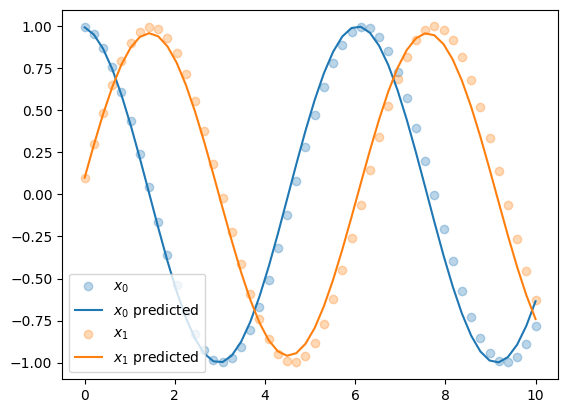

In [30]:
pred_traj = model.predict(times, trajectory[0])
dimension = len(trajectory[0])
for dim in range(dimension):
    plt.scatter(times, trajectory[:, dim], color = f'C{dim}', label=f'$x_{dim}$', marker='o', alpha=.3)
    plt.plot(times, pred_traj[:, dim],  color = f'C{dim}', label=f'$x_{dim}$ predicted')
plt.legend()